# LSTMs for Human Activity Recognition

Human activity recognition using smartwatch dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 

## Details about input data

I will be using an LSTM on the data to learn (as a smartwatch attached on the wrist) to recognise the type of activity that the user is doing. A similar dataset's description based on prior research goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data. 

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


## Results 

Scroll on! Nice visuals awaits. 

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "some_label"
]

# Output classes to learn how to classify
LABELS = [
    "LAYING_DOWN",
    "SITTING",
    "STANDING",
    "WALKING"
    
] 


## Let's start by downloading the data: 

In [3]:
import pandas as pd

input_file = "merged_jay.csv"

# comma delimited is the default
df = pd.read_csv(input_file, header = None, names = ["Timestamp","X","Y","Z","P","Label"])

In [4]:
df["Label"] = df["Label"].astype('category')

In [5]:
df.dtypes

Timestamp       int64
X             float64
Y             float64
Z             float64
P               int64
Label        category
dtype: object

In [6]:
df["Label"].value_counts()

laying_down    1232100
sitting         384286
walking         226655
standing        186664
Name: Label, dtype: int64

In [7]:
df["Label"] = df["Label"].cat.codes
df["Label"].value_counts()

0    1232100
1     384286
3     226655
2     186664
Name: Label, dtype: int64

In [8]:
df.describe()

,Timestamp,X,Y,Z,P,Label
count,2.029705e+06,2.029705e+06,2.029705e+06,2.029705e+06,2.029705e+06,2.029705e+06
mean,1.519213e+12,2.196267e+00,5.010439e-01,4.797433e+00,2.859706e+00,7.082699e-01
std,1.270435e+08,5.581570e+00,5.467828e+00,2.523419e+00,3.472917e-01,1.029840e+00
min,1.519084e+12,-1.960391e+01,-1.960391e+01,-1.960391e+01,2.000000e+00,0.000000e+00
25%,1.519087e+12,-2.159063e+00,-5.108028e+00,3.719717e+00,3.000000e+00,0.000000e+00
50%,1.519220e+12,4.409085e+00,2.676090e+00,4.772918e+00,3.000000e+00,0.000000e+00
75%,1.519284e+12,6.975067e+00,5.242072e+00,6.659107e+00,3.000000e+00,1.000000e+00
max,1.519759e+12,1.959434e+01,1.568648e+02,1.959434e+01,3.000000e+00,3.000000e+00


In [9]:
# create a numpy array with the numeric values for input into scikit-learn
numpy_array = df.as_matrix()

In [10]:
numpy_array.shape

(2029705, 6)

In [11]:
import random
from scipy import stats
X = []
Y = []
random.seed(1337)
data_size = 10000
while(len(X)<data_size):
    l = random.randint(0, numpy_array.shape[0]-512)
    X_values = numpy_array[l:l+512,1:5]
    Y_values = numpy_array[l:l+512,5]
    if (stats.describe(Y_values)[1][0] == stats.describe(Y_values)[1][1])and (stats.describe(Y_values)[1][0]!=-1): #if min and max are same
        X.append(X_values)
        Y.append(stats.describe(Y_values)[1][0])

In [12]:
X = np.asarray(X)
Y = np.asarray(Y)
print(X.shape)
print(Y.shape)

(10000, 512, 4)
(10000,)


## Preparing dataset:

In [13]:
split = int(.9*data_size)
X_train = X[0:split,]
y_train = Y[0:split,]
X_test = X[split:data_size,]
y_test = Y[split:data_size,]

In [14]:
print(X_train.shape)
print(y_train.shape)
print(set(y_train))
print(X_test.shape)
print(y_test.shape)
print(set(y_test))

(9000, 512, 4)
(9000,)
set([0.0, 1.0, 2.0, 3.0])
(1000, 512, 4)
(1000,)
set([0.0, 1.0, 2.0, 3.0])


# Testing on Cross subject dataset

In [15]:
input_file = "merged_shr.csv"

# comma delimited is the default
df = pd.read_csv(input_file, header = 0, names = ["Timestamp","X","Y","Z","P","Label"])
df["Label"] = df["Label"].astype('category')


In [16]:
df["Label"].value_counts()

laying_down    1134246
sitting        1015813
walking         673939
standing        641209
Name: Label, dtype: int64

In [17]:
df["Label"] = df["Label"].cat.codes
df["Label"].value_counts()

 0    1134246
 1    1015813
 3     673939
 2     641209
-1      28747
Name: Label, dtype: int64

In [18]:
numpy_array = df.as_matrix()
X_c = []
Y_c = []
random.seed(101)
data_size = 10000
while(len(X_c)<data_size):
    l = random.randint(0, numpy_array.shape[0]-512)
    X_values = numpy_array[l:l+512,1:5]
    Y_values = numpy_array[l:l+512,5]
    if (stats.describe(Y_values)[1][0] == stats.describe(Y_values)[1][1]) and (stats.describe(Y_values)[1][0]!=-1): #if min and max are same
        X_c.append(X_values)
        Y_c.append(stats.describe(Y_values)[1][0])
X_c = np.asarray(X_c)
Y_c = np.asarray(Y_c)

In [19]:
print(X_c.shape)
print(Y_c.shape)
print(set(Y_c))

(10000, 512, 4)
(10000,)
set([0.0, 1.0, 2.0, 3.0])


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [20]:
# Input Data 

training_data_count = len(X_train)  # 9000 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1000 testing series
n_steps = len(X_train[0])  # 512 timesteps per series
n_input = len(X_train[0][0])  # 4 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 4 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
dropout = 0.8
lambda_loss_amount = 0.0015
training_iters = training_data_count * 100  # Loop 10 times on the dataset
batch_size = 100
display_iter = 10000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
((1000, 512, 4), (1000,), 2.5607604715790657, 4.409608106139619)
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [21]:
stats.describe(y_test)

DescribeResult(nobs=1000, minmax=(0.0, 3.0), mean=0.75, variance=1.1206206206206206, skewness=1.1238891379506741, kurtosis=-0.17419048931793135)

## Utility functions for training:

In [22]:
def LSTM_RNN(_X, _weights, _biases, _keep_prob):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']
    # Dropout
    _X = tf.nn.dropout(_X, _keep_prob)
    #RELU
    _X = tf.nn.relu(_X)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [23]:
one_hot(np.asarray([[3], [0], [3]]))

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

## Let's get serious and build the neural network:

In [24]:
tf.reset_default_graph()
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases, keep_prob)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Hooray, now train the neural network:

In [25]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
test_cross_losses = []
test_cross_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
saver = tf.train.Saver()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
saver.save(sess, './Checkpoints/mytestmodel.ckpt')

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys,
            keep_prob : dropout
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        saver.save(sess, './Checkpoints/mytestmodel.ckpt', global_step=step,write_meta_graph=False)
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test),
                keep_prob : 1.0
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the cross test set (no learning made here - just evaluation for diagnosis)
        loss_c, acc_c = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_c,
                y: one_hot(Y_c),
                keep_prob : 1.0
            }
        )
        test_cross_losses.append(loss_c)
        test_cross_accuracies.append(acc_c)
        print("PERFORMANCE ON CROSS TEST SET: " + \
              "Batch Loss = {}".format(loss_c) + \
              ", Accuracy = {}".format(acc_c))

    step += 1

print("Optimization Finished!")
saver.save(sess, './Checkpoints/final/finalmodel.ckpt')

Training iter #100:   Batch Loss = 2.493585, Accuracy = 0.119999997318
PERFORMANCE ON TEST SET: Batch Loss = 1.80390822887, Accuracy = 0.137999996543
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.85620200634, Accuracy = 0.212699994445
Training iter #10000:   Batch Loss = 0.635054, Accuracy = 0.910000026226
PERFORMANCE ON TEST SET: Batch Loss = 0.645298361778, Accuracy = 0.889999985695
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.55128920078, Accuracy = 0.571699976921
Training iter #20000:   Batch Loss = 0.477034, Accuracy = 0.939999997616
PERFORMANCE ON TEST SET: Batch Loss = 0.57845801115, Accuracy = 0.893999993801
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.55063712597, Accuracy = 0.593599975109
Training iter #30000:   Batch Loss = 0.461682, Accuracy = 0.920000016689
PERFORMANCE ON TEST SET: Batch Loss = 0.532626211643, Accuracy = 0.907000005245
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.42666113377, Accuracy = 0.631299972534
Training iter #40000:   Batch Loss = 0.568649, Accur

PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.16763222218, Accuracy = 0.62809997797
Training iter #350000:   Batch Loss = 0.276754, Accuracy = 0.959999978542
PERFORMANCE ON TEST SET: Batch Loss = 0.286339968443, Accuracy = 0.940999984741
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.33381974697, Accuracy = 0.649500012398
Training iter #360000:   Batch Loss = 0.207546, Accuracy = 0.97000002861
PERFORMANCE ON TEST SET: Batch Loss = 0.293058484793, Accuracy = 0.947000026703
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.39176118374, Accuracy = 0.66369998455
Training iter #370000:   Batch Loss = 0.261898, Accuracy = 0.959999978542
PERFORMANCE ON TEST SET: Batch Loss = 0.295982509851, Accuracy = 0.925999999046
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.11862337589, Accuracy = 0.664099991322
Training iter #380000:   Batch Loss = 0.204951, Accuracy = 0.959999978542
PERFORMANCE ON TEST SET: Batch Loss = 0.330445021391, Accuracy = 0.930999994278
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.3

PERFORMANCE ON TEST SET: Batch Loss = 0.197104200721, Accuracy = 0.962000012398
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.39301717281, Accuracy = 0.644900023937
Training iter #700000:   Batch Loss = 0.122721, Accuracy = 1.0
PERFORMANCE ON TEST SET: Batch Loss = 0.290351599455, Accuracy = 0.940999984741
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.31220602989, Accuracy = 0.619099974632
Training iter #710000:   Batch Loss = 0.270127, Accuracy = 0.939999997616
PERFORMANCE ON TEST SET: Batch Loss = 0.420501500368, Accuracy = 0.871999979019
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.24045050144, Accuracy = 0.639199972153
Training iter #720000:   Batch Loss = 0.204833, Accuracy = 0.959999978542
PERFORMANCE ON TEST SET: Batch Loss = 0.262026965618, Accuracy = 0.947000026703
PERFORMANCE ON CROSS TEST SET: Batch Loss = 1.32458472252, Accuracy = 0.650399982929
Training iter #730000:   Batch Loss = 0.169445, Accuracy = 0.980000019073
PERFORMANCE ON TEST SET: Batch Loss = 0.261676579714, A

'./Checkpoints/final/finalmodel.ckpt'

In [34]:
# Accuracy for test data
sess = tf.Session()
saver.restore(sess, "./Checkpoints/final/finalmodel.ckpt")
one_hot_predictions, acc, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test),
        keep_prob : 1.0
    }
)

test_losses.append(final_loss)
test_accuracies.append(acc)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(acc))

INFO:tensorflow:Restoring parameters from ./Checkpoints/final/finalmodel.ckpt
FINAL RESULT: Batch Loss = 0.238585025072, Accuracy = 0.958999991417


In [35]:
# Accuracy for cross test data
one_hot_predictions_c, accuracy_c, final_loss_c = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_c,
        y: one_hot(Y_c),
        keep_prob : 1.0
    }
)

print("FINAL RESULT Cross Data: " + \
      "Batch Loss = {}".format(final_loss_c) + \
      ", Accuracy = {}".format(accuracy_c))

FINAL RESULT Cross Data: Batch Loss = 1.33246600628, Accuracy = 0.635500013828


## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

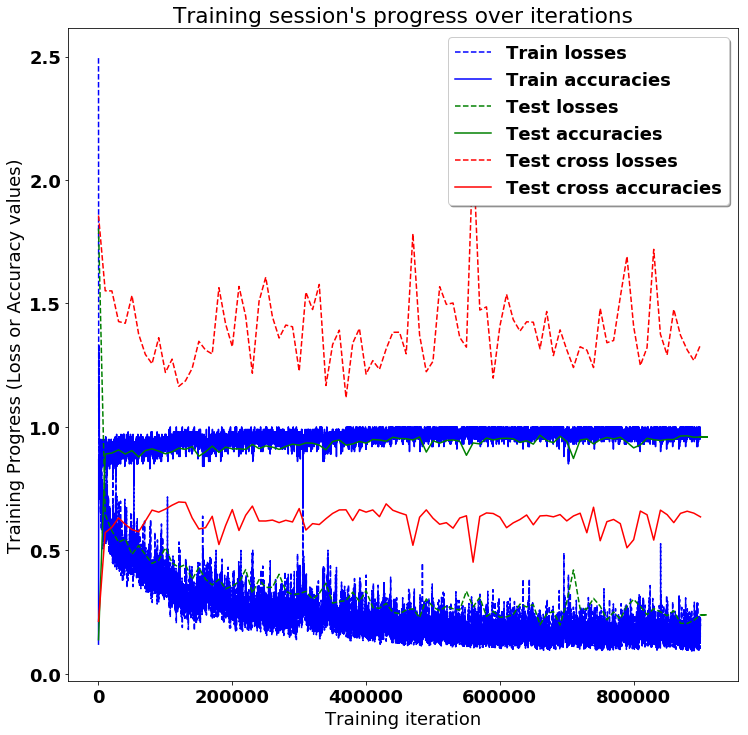

In [36]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "b-", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "g--", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

indep_test_c_axis = np.append(
   np.array(range(batch_size, len(test_cross_losses)*display_iter, display_iter)[:-1]),
   [training_iters]
)
plt.plot(indep_test_c_axis, np.array(test_cross_losses),     "r--", label="Test cross losses")
plt.plot(indep_test_c_axis, np.array(test_cross_accuracies), "r-", label="Test cross accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: Tensor("mul_6:0", shape=(), dtype=float32)%

Precision: 96.0313235883%
Recall: 95.9%
f1_score: 95.941159426%

Confusion Matrix:
[[579   2   4  10]
 [  1 177   1   2]
 [  2   4  91   6]
 [  0   3   6 112]]

Confusion matrix (normalised to % of total test data):
[[57.9       0.2       0.4       1.      ]
 [ 0.1      17.7       0.1       0.2     ]
 [ 0.2       0.4       9.099999  0.6     ]
 [ 0.        0.3       0.6      11.200001]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 4th of the data is correctly classifier in the last category.


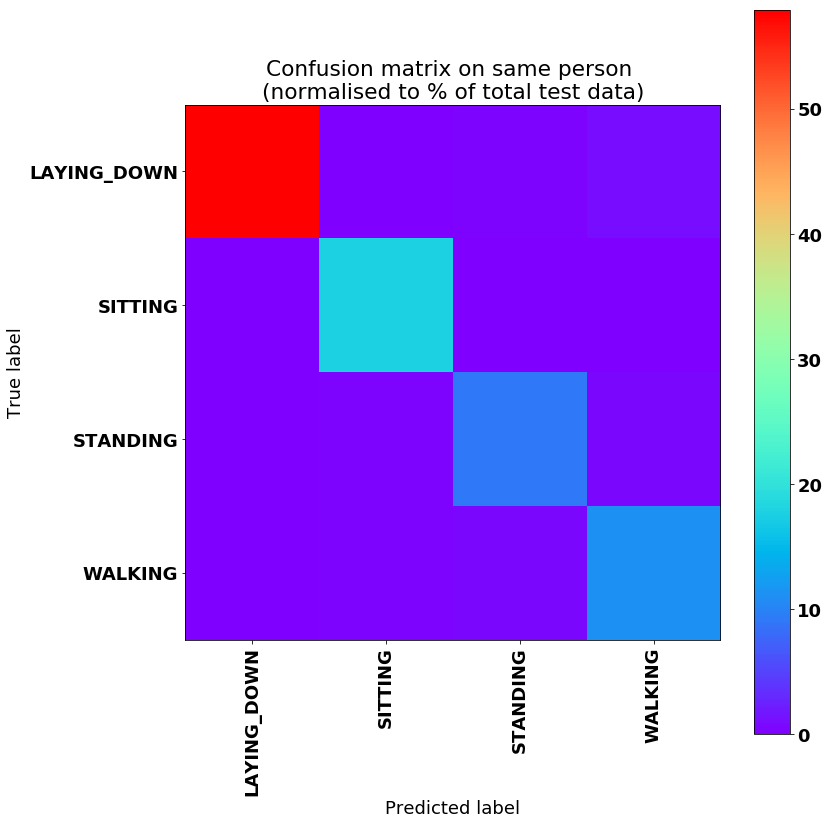

In [44]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 4th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix on same person \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Testing Accuracy: Tensor("mul_7:0", shape=(), dtype=float32)%

Precision: 65.2050909701%
Recall: 63.55%
f1_score: 63.0264378139%

Confusion Matrix:
[[2715   83  426   98]
 [ 559  958 1299   70]
 [  25  559  974  321]
 [  11   64  130 1708]]

Confusion matrix (normalised to % of total test data):
[[27.15        0.83        4.2599998   0.98      ]
 [ 5.59        9.58       12.99        0.70000005]
 [ 0.25        5.59        9.74        3.21      ]
 [ 0.11        0.64        1.3000001  17.08      ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 4th of the data is correctly classifier in the last category.


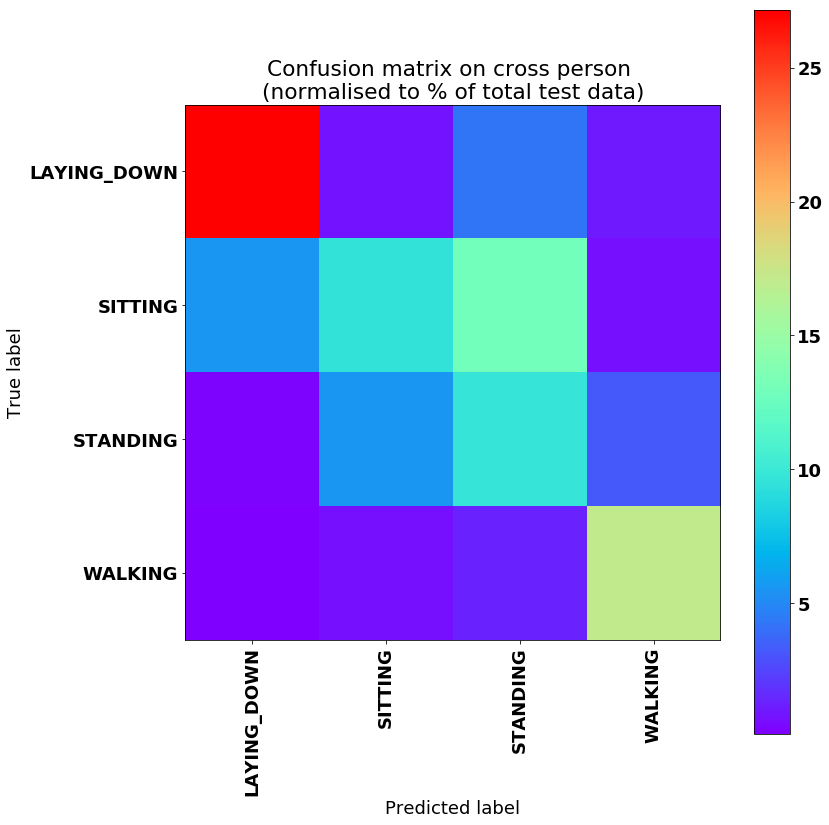

In [45]:
# Results

predictions = one_hot_predictions_c.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(Y_c, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Y_c, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Y_c, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Y_c, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 4th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix on cross person \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of 93.6%**! And it can peak to values such as 95.6%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly. 

This means that the neural networks is almost always able to correctly identify the movement type!

I specially did not expect such good results for guessing between "WALKING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at wrist level according to how the dataset was gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away from the identity. This is great.

## References

The code is based on the following repository: 
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition


In [46]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Support files will be in LSTM_files/
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Writing 48861 bytes to LSTM.md
